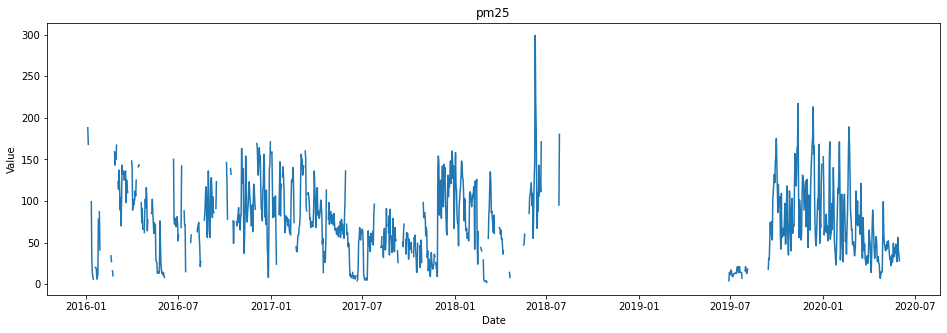

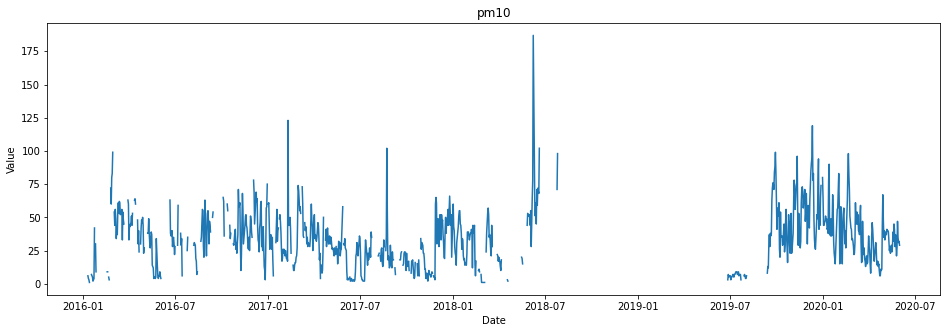

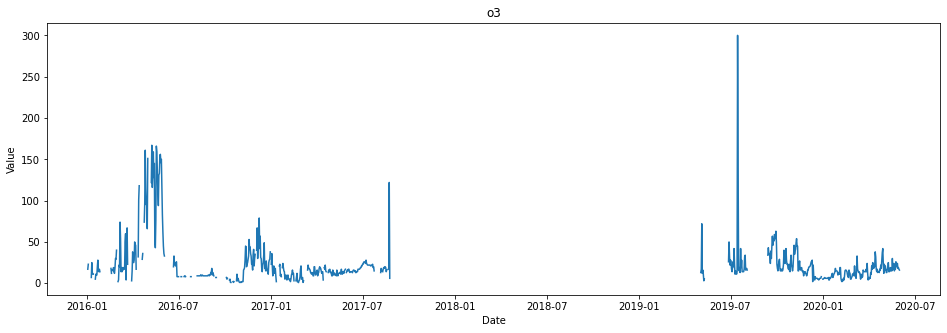

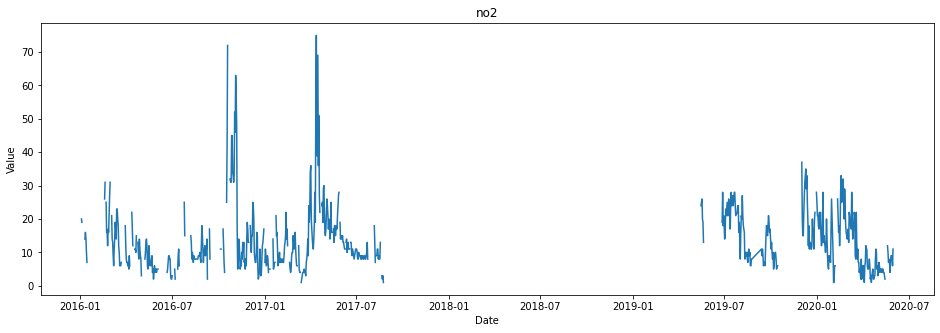

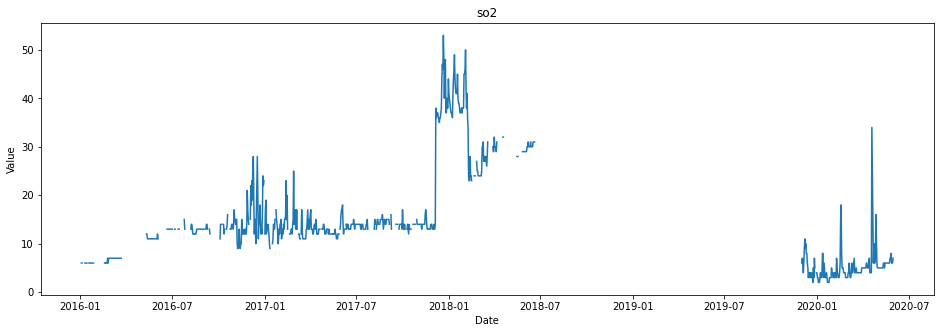

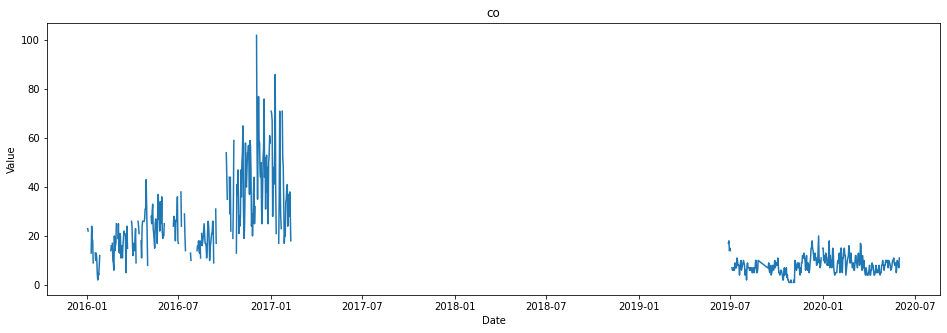

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

aqi = pd.read_csv('/content/hanoi-air-quality.csv', parse_dates=["date"], date_parser=pd.to_datetime)
aqi.set_index(keys=["date"], inplace=True)


def plot_series(x, y, z=None, title="", xlabel='Date', ylabel='Value', txt=None, multiple_plots=False):
    plt.figure(figsize=(16,5))
    plt.plot(x, y, label='real')
    if multiple_plots:
        plt.plot(x, z, label='predicted')
        plt.annotate(f'RMSE: {txt}', xy=(0.45, 0.9), xycoords='axes fraction')
        plt.legend()
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


plot_series(x=aqi.index, y=aqi.pm25, title="pm25")
plot_series(x=aqi.index, y=aqi.pm10, title="pm10")
plot_series(x=aqi.index, y=aqi.o3, title="o3")
plot_series(x=aqi.index, y=aqi.no2, title="no2")
plot_series(x=aqi.index, y=aqi.so2, title="so2")
plot_series(x=aqi.index, y=aqi.co, title="co")

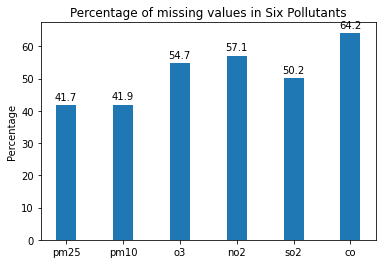

In [4]:
dates = list(pd.date_range(min(aqi.index), max(aqi.index), freq='D').values)
aqi = aqi.reindex(dates)

weather = pd.read_csv('/content/weather.csv', parse_dates=["date"], date_parser=pd.to_datetime)
weather.set_index(keys=["date"], inplace=True)

data = pd.merge(aqi, weather, left_index=True, right_index=True)
columns_name = data.columns


def plot_percent_missing(data):
    def percent_missing(p):
        return p.isnull().sum() * 100 / len(p)
    fig, ax = plt.subplots()
    pollutants = ('pm25', 'pm10', 'o3', 'no2', 'so2', 'co')
    y = np.arange(len(pollutants))
    p = np.round([percent_missing(data.pm25), percent_missing(data.pm10), percent_missing(data.o3),
             percent_missing(data.no2), percent_missing(data.so2), percent_missing(data.co)], 1)
    rect = ax.bar(y, p, 0.35)
    plt.xticks(y, pollutants)
    plt.ylabel('Percentage')
    plt.title('Percentage of missing values in Six Pollutants')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rect)
    plt.show()


plot_percent_missing(data)

Preprocessing data:

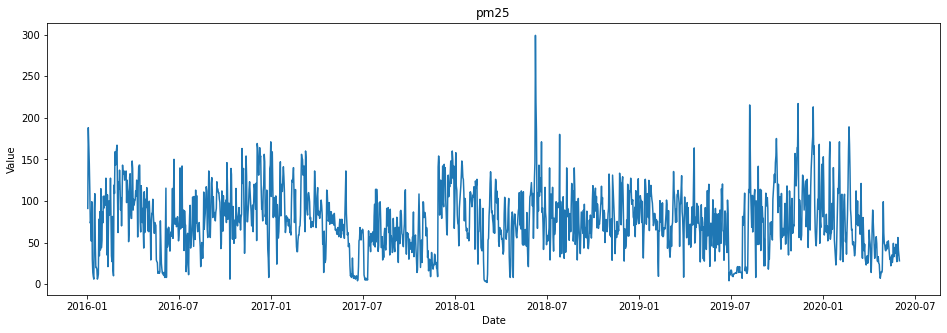

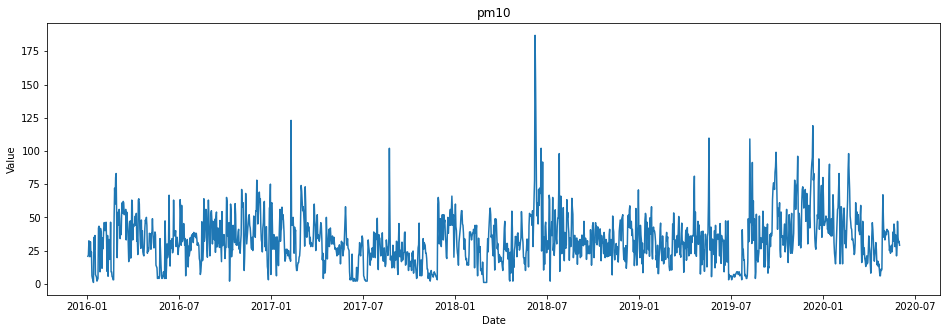

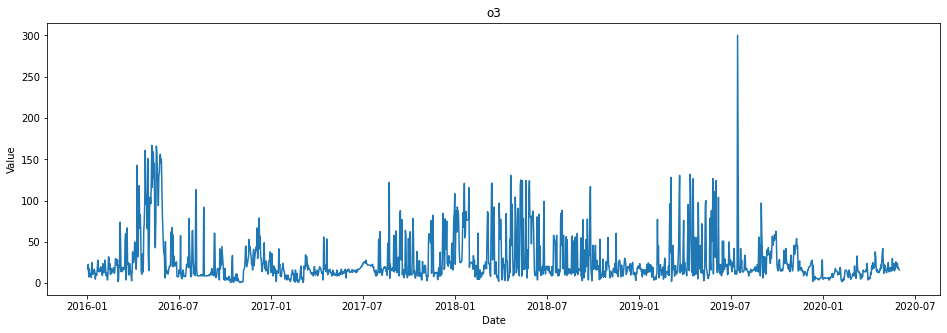

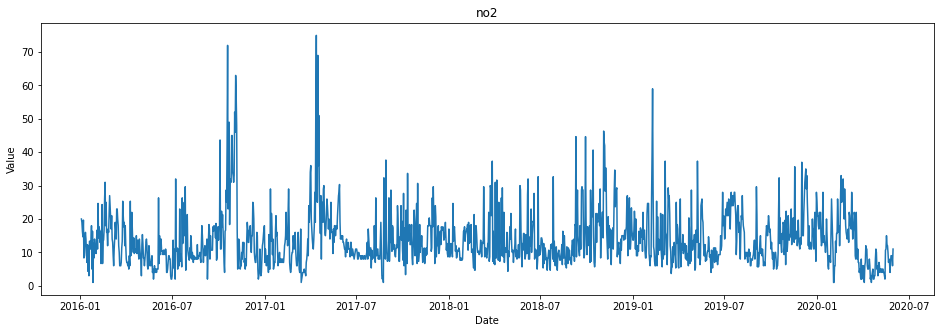

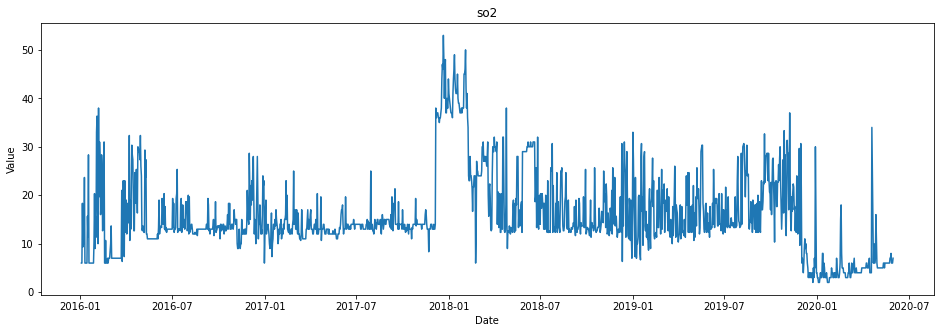

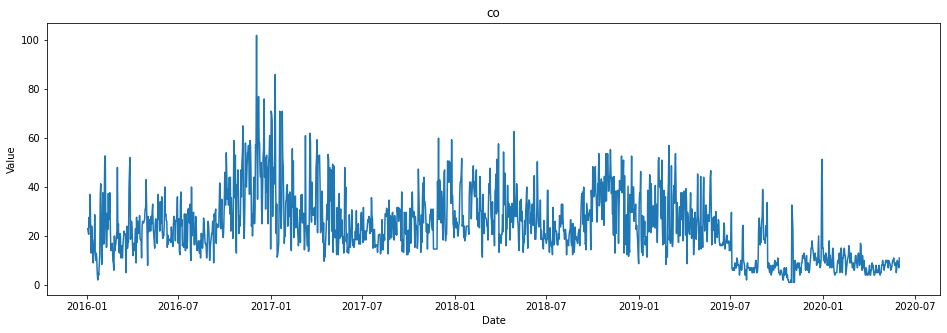

In [16]:
train = data.query('date <= "2018-12-31"')
valid = data.query('date >= "2019-01-01" and date <= "2019-12-31"')
test = data.query('date >= "2020-01-01"')

imputer = KNNImputer(n_neighbors=3)
imputed_train = imputer.fit_transform(train)
imputed_valid = imputer.transform(valid)
imputed_test = imputer.transform(test)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(imputed_train)
scaled_valid = scaler.transform(imputed_valid)
scaled_test = scaler.fit_transform(imputed_test)
final_train = pd.DataFrame(scaled_train, columns=train.columns)
final_valid = pd.DataFrame(scaled_valid, columns=valid.columns)
final_test = pd.DataFrame(scaled_test, columns=test.columns)

imputed_data = np.concatenate([imputed_train, imputed_valid, imputed_test], axis=0)
imputed_data = pd.DataFrame(imputed_data, columns=data.columns)

plot_series(x=data.index, y=imputed_data.pm25, title='pm25')
plot_series(x=data.index, y=imputed_data.pm10, title="pm10")
plot_series(x=data.index, y=imputed_data.o3, title="o3")
plot_series(x=data.index, y=imputed_data.no2, title="no2")
plot_series(x=data.index, y=imputed_data.so2, title="so2")
plot_series(x=data.index, y=imputed_data.co, title="co")

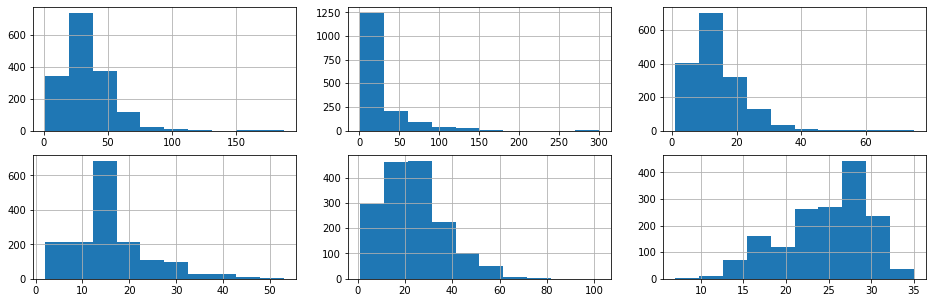

In [10]:
def plot_histogram(data):
    plt.figure(figsize=(16,5))
    for i in range(1,7):
        plt.subplot(2,3,i)
        data.iloc[:,i].hist()
    plt.show()


plot_histogram(imputed_data)

Check if time series is stationary:

In [11]:
def adfuller_test(data, signif=0.05, name=''):
    result = adfuller(data, autolag="AIC")
    output = {'ADF Statistic': round(result[0], 3),
              'p-value': round(result[1], 3)}
    p_value = output['p-value']
    print(f' Augmented Dickey-Fuller Test on "{name}":')
    print(f' Significance Level = {signif}')
    print(f' ADF Statistic     = {output["ADF Statistic"]}')
    for key, value in result[4].items():
        print(f' Critical value {key} = {round(value, 3)}')
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


for name, column in imputed_data.iloc[:, 0:6].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

 Augmented Dickey-Fuller Test on "pm25":
 Significance Level = 0.05
 ADF Statistic     = -7.576
 Critical value 1% = -3.434
 Critical value 5% = -2.863
 Critical value 10% = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "pm10":
 Significance Level = 0.05
 ADF Statistic     = -11.251
 Critical value 1% = -3.434
 Critical value 5% = -2.863
 Critical value 10% = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "o3":
 Significance Level = 0.05
 ADF Statistic     = -5.08
 Critical value 1% = -3.434
 Critical value 5% = -2.863
 Critical value 10% = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "no2":
 Significance Level = 0.05
 ADF Statistic     = -8.256
 Critical value 1% = -3.434
 Critical value 5% = -2.863
 Critical value 10% = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series 

In [0]:
def create_data_for_each_pollutant(data):
    splitdata = []
    for i in range(6):
        splitdata.append(data.iloc[:, [i, 6, 7, 8, 9]])
    return splitdata[0], splitdata[1], splitdata[2], splitdata[3], splitdata[4], splitdata[5]


train_pm25, train_pm10, train_o3, train_no2, train_so2, train_co = create_data_for_each_pollutant(final_train)
valid_pm25, valid_pm10, valid_o3, valid_no2, valid_so2, valid_co = create_data_for_each_pollutant(final_valid)
test_pm25, test_pm10, test_o3, test_no2, test_so2, test_co = create_data_for_each_pollutant(final_test)

Vector Autoregression Model:

In [17]:
def training_VAR(train, valid):
    model = VAR(train)
    print(model.select_order())
    lag_order = 4
    fitted = model.fit(lag_order)
    y_hat_train = np.zeros((train.shape[0]-lag_order, 1))
    for i in range(train.shape[0]-lag_order):
        y_hat_train[i] = fitted.forecast(train.values[i:i+lag_order], steps=1)[:, 0]
    y_hat_valid = np.zeros((valid.shape[0]-lag_order, 1))
    for i in range(valid.shape[0]-lag_order):
        y_hat_valid[i] = fitted.forecast(valid.values[i:i+lag_order], steps=1)[:, 0]
    print('loss: %f' %(mean_absolute_error(train.values[lag_order:, 0], y_hat_train)),
          'val_loss: %f' %mean_absolute_error(valid.values[lag_order:, 0], y_hat_valid))
    return fitted


def predict(fitted, test):
    lag_order = 4
    y_hat_test = np.zeros((test.shape[0] - lag_order, 1))
    for i in range(test.shape[0] - lag_order):
        y_hat_test[i] = fitted.forecast(test.values[i:i + lag_order], steps=1)[:, 0]
    return y_hat_test


fitted_pm25 = training_VAR(train_pm25, valid_pm25)
fitted_pm10 = training_VAR(train_pm10, valid_pm10)
fitted_o3 = training_VAR(train_o3, valid_o3)
fitted_no2 = training_VAR(train_no2, valid_no2)
fitted_so2 = training_VAR(train_so2, valid_so2)
fitted_co = training_VAR(train_co, valid_co)

y_hat_pm25 = predict(fitted_pm25, test_pm25)
y_hat_pm10 = predict(fitted_pm10, test_pm10)
y_hat_o3 = predict(fitted_o3, test_o3)
y_hat_no2 = predict(fitted_no2, test_no2)
y_hat_so2 = predict(fitted_so2, test_so2)
y_hat_co = predict(fitted_co, test_co)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 5, BIC -> 2, FPE -> 5, HQIC -> 2>
loss: 0.067695 val_loss: 0.076541
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 2, FPE -> 4, HQIC -> 2>
loss: 0.051760 val_loss: 0.065178
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 2, FPE -> 4, HQIC -> 2>
loss: 0.086856 val_loss: 0.095435
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 2, FPE -> 4, HQIC -> 3>
loss: 0.062518 val_loss: 0.062654
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 2, FPE -> 4, HQIC -> 3>
loss: 0.059160 val_loss: 0.088323
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 2, FPE -> 4, HQIC -> 2>
loss: 0.072795 val_loss: 0.086017


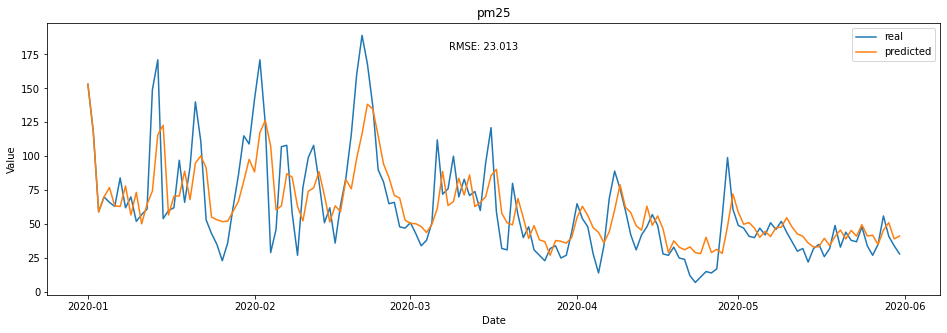

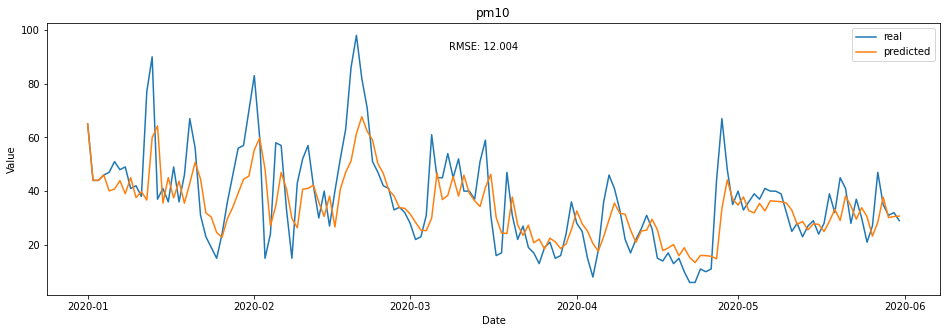

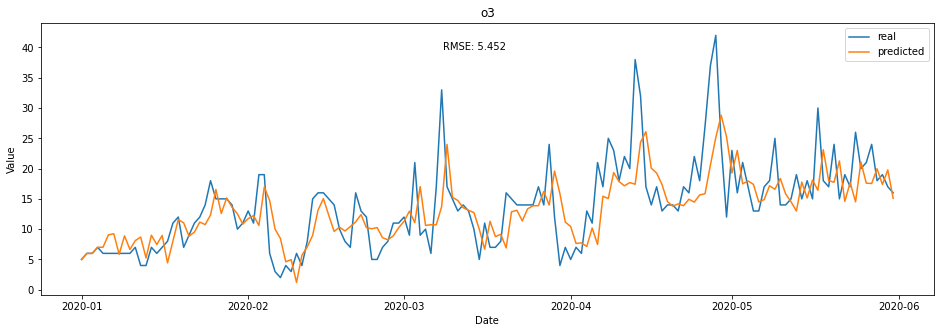

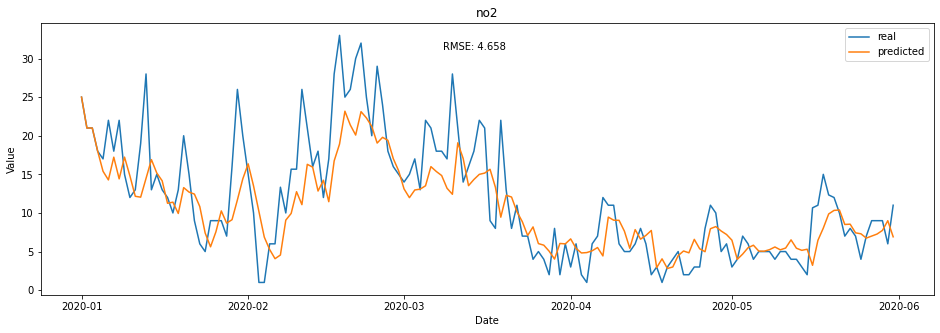

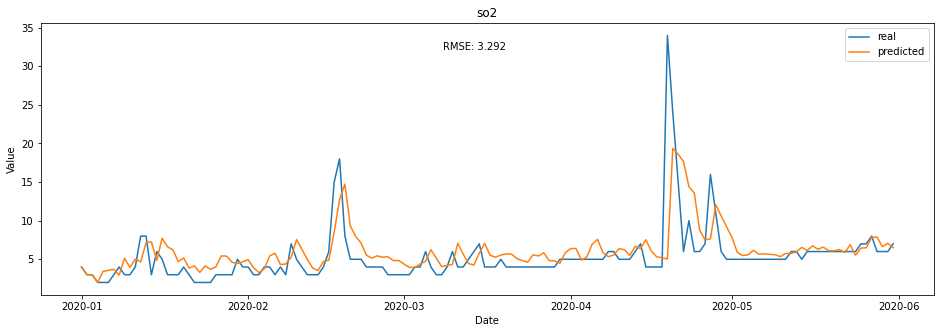

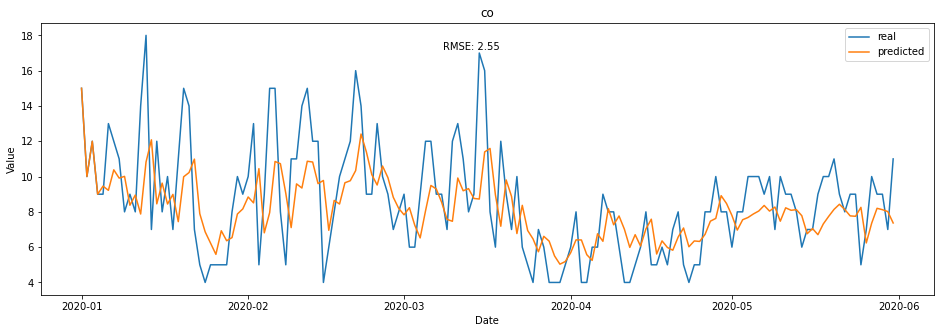

In [18]:
def evaluate(y_hat, lag_order, n_out):
    if n_out > 1:
        for i in range(6):
            y_hat[i] = np.insert(y_hat[i], [y_hat[i].shape[0]], np.empty((n_out-1,n_out)), axis=0)
            for j in range(y_hat[i].shape[1]):
                y_hat[i][:, j] = np.roll(y_hat[i][:, j], j, axis=0)
            y_hat[i] = np.nanmean(y_hat[i], axis=1).reshape(-1, 1)
    y_hat = np.concatenate([y_hat[0], y_hat[1], y_hat[2], y_hat[3], y_hat[4], y_hat[5]], axis=1)
    y_hat = pd.concat([final_test.iloc[0:lag_order, :6], pd.DataFrame(y_hat, columns=test.columns[:6])], axis=0, ignore_index=True)
    predicted = pd.concat([y_hat, final_test.iloc[:, 6:]], axis=1)
    predicted = pd.DataFrame(scaler.inverse_transform(predicted), columns=test.columns)
    for i in range(6):
        rmse = round(np.sqrt(mean_squared_error(imputed_test[:, i], predicted.iloc[:, i])),3)
        plot_series(x=test.index, y=imputed_test[:, i], z=predicted.iloc[:, i], title=predicted.columns[i],
                    txt=rmse, multiple_plots=True)


evaluate([y_hat_pm25, y_hat_pm10, y_hat_o3, y_hat_no2, y_hat_so2, y_hat_co], 4, 1)

LSTM Model:

Create Input Data for LSTM:

In [0]:
def series_to_supervised(data, n_in, n_out, n_features, dropnan=True):
    n_vars = data.shape[1]
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]
    for i in range(n_out):
        cols.append(data.shift(-i))
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    if n_features > 1:
        agg.drop(agg.columns[-n_features+1:], axis=1, inplace=True)
        if n_out > 1:
            for i in range(1, n_out):
                agg.drop(agg.columns[-n_features-(i-1):-i], axis=1, inplace=True)
    return agg.values


n_in = 4
n_out = 1
n_features = 5
train_pm25_sp = series_to_supervised(train_pm25, n_in, n_out, n_features)
train_pm10_sp = series_to_supervised(train_pm10, n_in, n_out, n_features)
train_o3_sp = series_to_supervised(train_o3, n_in, n_out, n_features)
train_no2_sp = series_to_supervised(train_no2, n_in, n_out, n_features)
train_so2_sp = series_to_supervised(train_so2, n_in, n_out, n_features)
train_co_sp = series_to_supervised(train_co, n_in, n_out, n_features)

valid_pm25_sp = series_to_supervised(valid_pm25, n_in, n_out, n_features)
valid_pm10_sp = series_to_supervised(valid_pm10, n_in, n_out, n_features)
valid_o3_sp = series_to_supervised(valid_o3, n_in, n_out, n_features)
valid_no2_sp = series_to_supervised(valid_no2, n_in, n_out, n_features)
valid_so2_sp = series_to_supervised(valid_so2, n_in, n_out, n_features)
valid_co_sp = series_to_supervised(valid_co, n_in, n_out, n_features)

X_train_pm25, y_train_pm25 = train_pm25_sp[:, np.newaxis, :-n_out].reshape((train_pm25_sp.shape[0], n_in, n_features)),\
                             train_pm25_sp[:, -n_out:]
X_valid_pm25, y_valid_pm25 = valid_pm25_sp[:, np.newaxis, :-n_out].reshape((valid_pm25_sp.shape[0], n_in, n_features)),\
                             valid_pm25_sp[:, -n_out:]
X_train_pm10, y_train_pm10 = train_pm10_sp[:, np.newaxis, :-n_out].reshape((train_pm10_sp.shape[0], n_in, n_features)),\
                             train_pm10_sp[:, -n_out:]
X_valid_pm10, y_valid_pm10 = valid_pm10_sp[:, np.newaxis, :-n_out].reshape((valid_pm10_sp.shape[0], n_in, n_features)),\
                             valid_pm10_sp[:, -n_out:]
X_train_o3, y_train_o3 = train_o3_sp[:, np.newaxis, :-n_out].reshape((train_o3_sp.shape[0], n_in, n_features)),\
                         train_o3_sp[:, -n_out:]
X_valid_o3, y_valid_o3 = valid_o3_sp[:, np.newaxis, :-n_out].reshape((valid_o3_sp.shape[0], n_in, n_features)),\
                         valid_o3_sp[:, -n_out:]
X_train_no2, y_train_no2 = train_no2_sp[:, np.newaxis, :-n_out].reshape((train_no2_sp.shape[0], n_in, n_features)),\
                           train_no2_sp[:, -n_out:]
X_valid_no2, y_valid_no2 = valid_no2_sp[:, np.newaxis, :-n_out].reshape((valid_no2_sp.shape[0], n_in, n_features)),\
                           valid_no2_sp[:, -n_out:]
X_train_so2, y_train_so2 = train_so2_sp[:, np.newaxis, :-n_out].reshape((train_so2_sp.shape[0], n_in, n_features)),\
                           train_so2_sp[:, -n_out:]
X_valid_so2, y_valid_so2 = valid_so2_sp[:, np.newaxis, :-n_out].reshape((valid_so2_sp.shape[0], n_in, n_features)),\
                           valid_so2_sp[:, -n_out:]
X_train_co, y_train_co = train_co_sp[:, np.newaxis, :-n_out].reshape((train_co_sp.shape[0], n_in, n_features)),\
                         train_co_sp[:, -n_out:]
X_valid_co, y_valid_co = valid_co_sp[:, np.newaxis, :-n_out].reshape((valid_co_sp.shape[0], n_in, n_features)),\
                         valid_co_sp[:, -n_out:]

In [23]:
def training_LSTM(model, X_train , y_train, X_valid, y_valid, pos):
    model.compile(loss="mae", optimizer="adam")
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, min_delta=0.0001)
    history = model.fit(X_train, y_train, epochs=100, batch_size=16,
                        validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])
    # model.save(f'model/{n_out}_step/{columns_name[pos]}_model.h5')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.ylim(0.05, 0.3)
    plt.legend()
    plt.show()


model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[n_in, n_features]),
    keras.layers.LSTM(20),
    keras.layers.Dense(n_out)
])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4, 20)             2080      
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 5,381
Trainable params: 5,381
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
69/69 [==============================] - 1s 15ms/step - loss: 0.1044 - val_loss: 0.0943
Epoch 2/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0871 - val_loss: 0.0889
Epoch 3/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0842 - val_loss: 0.0927
Epoch 4/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0820 - val_loss: 0.0877
Epoch 5/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0815 - val_loss: 0.0864
Epoch 6/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0797 - val_loss: 0.0912
Epoch 7/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0815 - val_loss: 0.0874
Epoch 8/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0786 - val_loss: 0.0849
Epoch 9/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0791 - val_loss: 0.0854
Epoch 10/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0774 - val_loss: 0.0857
Epoch 11

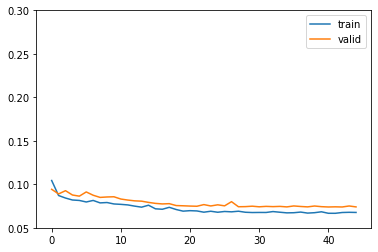

Epoch 1/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0528 - val_loss: 0.0634
Epoch 2/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0522 - val_loss: 0.0629
Epoch 3/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0518 - val_loss: 0.0627
Epoch 4/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0523 - val_loss: 0.0619
Epoch 5/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0515 - val_loss: 0.0652
Epoch 6/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0518 - val_loss: 0.0626
Epoch 7/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0512 - val_loss: 0.0618
Epoch 8/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 0.0630
Epoch 9/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0514 - val_loss: 0.0632
Epoch 10/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0512 - val_loss: 0.0612
Epoch 11

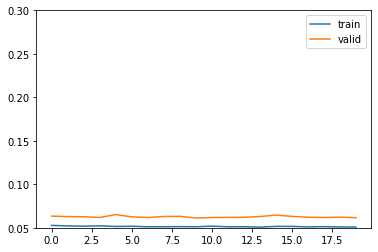

Epoch 1/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0851 - val_loss: 0.0895
Epoch 2/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0836 - val_loss: 0.0882
Epoch 3/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0830 - val_loss: 0.0870
Epoch 4/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0820 - val_loss: 0.0865
Epoch 5/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0819 - val_loss: 0.0872
Epoch 6/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0813 - val_loss: 0.0861
Epoch 7/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0818 - val_loss: 0.0861
Epoch 8/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0813 - val_loss: 0.0864
Epoch 9/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0820 - val_loss: 0.0890
Epoch 10/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0809 - val_loss: 0.0870
Epoch 11

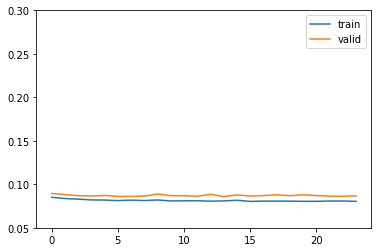

Epoch 1/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0637 - val_loss: 0.0605
Epoch 2/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0629 - val_loss: 0.0634
Epoch 3/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0628 - val_loss: 0.0603
Epoch 4/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0622 - val_loss: 0.0609
Epoch 5/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0622 - val_loss: 0.0604
Epoch 6/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0620 - val_loss: 0.0604
Epoch 7/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0621 - val_loss: 0.0609
Epoch 8/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0619 - val_loss: 0.0610
Epoch 9/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0615 - val_loss: 0.0609
Epoch 10/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0618 - val_loss: 0.0612
Epoch 11

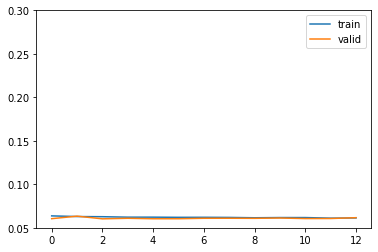

Epoch 1/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0593 - val_loss: 0.0888
Epoch 2/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0574 - val_loss: 0.0883
Epoch 3/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0571 - val_loss: 0.0875
Epoch 4/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0573 - val_loss: 0.0881
Epoch 5/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0571 - val_loss: 0.0889
Epoch 6/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0565 - val_loss: 0.0879
Epoch 7/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0566 - val_loss: 0.0877
Epoch 8/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0563 - val_loss: 0.0877
Epoch 9/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0572 - val_loss: 0.0878
Epoch 10/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0562 - val_loss: 0.0876
Epoch 11

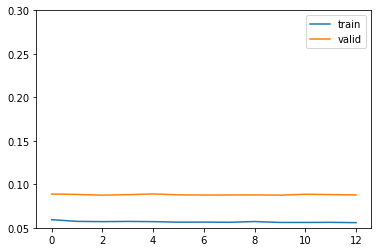

Epoch 1/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0747 - val_loss: 0.0701
Epoch 2/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0733 - val_loss: 0.0818
Epoch 3/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0732 - val_loss: 0.0809
Epoch 4/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0732 - val_loss: 0.0743
Epoch 5/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0728 - val_loss: 0.0791
Epoch 6/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0728 - val_loss: 0.0708
Epoch 7/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0729 - val_loss: 0.0774
Epoch 8/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0731 - val_loss: 0.0750
Epoch 9/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0724 - val_loss: 0.0827
Epoch 10/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0721 - val_loss: 0.0721
Epoch 11

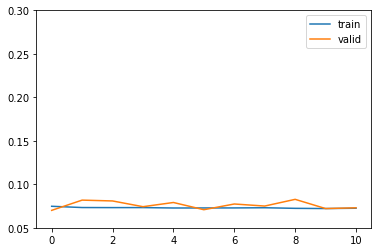

In [24]:
test_pm25_sp = series_to_supervised(test_pm25, n_in, n_out, n_features)
test_pm10_sp = series_to_supervised(test_pm10, n_in, n_out, n_features)
test_o3_sp = series_to_supervised(test_o3, n_in, n_out, n_features)
test_no2_sp = series_to_supervised(test_no2, n_in, n_out, n_features)
test_so2_sp = series_to_supervised(test_so2, n_in, n_out, n_features)
test_co_sp = series_to_supervised(test_co, n_in, n_out, n_features)

X_test_pm25, y_test_pm25 = test_pm25_sp[:, np.newaxis, :-n_out].reshape((test_pm25_sp.shape[0], n_in, n_features)),\
                           test_pm25_sp[:, -n_out]
X_test_pm10, y_test_pm10 = test_pm10_sp[:, np.newaxis, :-n_out].reshape((test_pm10_sp.shape[0], n_in, n_features)),\
                           test_pm10_sp[:, -n_out]
X_test_o3, y_test_o3 = test_o3_sp[:, np.newaxis, :-n_out].reshape((test_o3_sp.shape[0], n_in, n_features)),\
                       test_o3_sp[:, -n_out]
X_test_no2, y_test_no2 = test_no2_sp[:, np.newaxis, :-n_out].reshape((test_no2_sp.shape[0], n_in, n_features)),\
                         test_no2_sp[:, -n_out]
X_test_so2, y_test_so2 = test_so2_sp[:, np.newaxis, :-n_out].reshape((test_so2_sp.shape[0], n_in, n_features)),\
                         test_so2_sp[:, -n_out]
X_test_co, y_test_co = test_co_sp[:, np.newaxis, :-n_out].reshape((test_co_sp.shape[0], n_in, n_features)),\
                       test_co_sp[:, -n_out]

training_LSTM(model, X_train_pm25, y_train_pm25, X_valid_pm25, y_valid_pm25, 0)
y_hat_pm25 = model.predict(X_test_pm25)
training_LSTM(model, X_train_pm10, y_train_pm10, X_valid_pm10, y_valid_pm10, 1)
y_hat_pm10 = model.predict(X_test_pm10)
training_LSTM(model, X_train_o3, y_train_o3, X_valid_o3, y_valid_o3, 2)
y_hat_o3 = model.predict(X_test_o3)
training_LSTM(model, X_train_no2, y_train_no2, X_valid_no2, y_valid_no2, 3)
y_hat_no2 = model.predict(X_test_no2)
training_LSTM(model, X_train_so2, y_train_so2, X_valid_so2, y_valid_so2, 4)
y_hat_so2 = model.predict(X_test_so2)
training_LSTM(model, X_train_co, y_train_co, X_valid_co, y_valid_co, 5)
y_hat_co = model.predict(X_test_co)

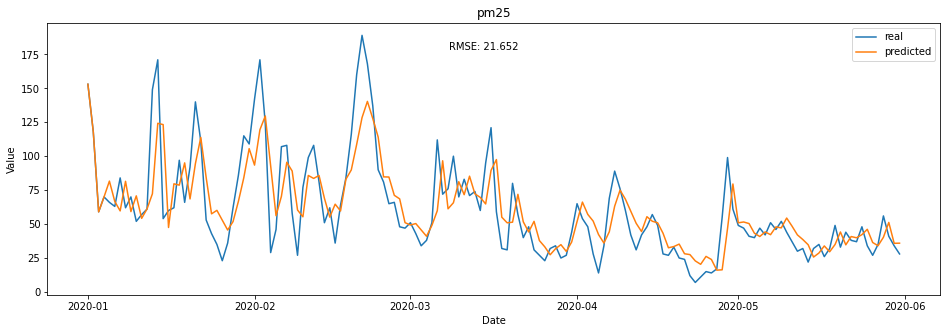

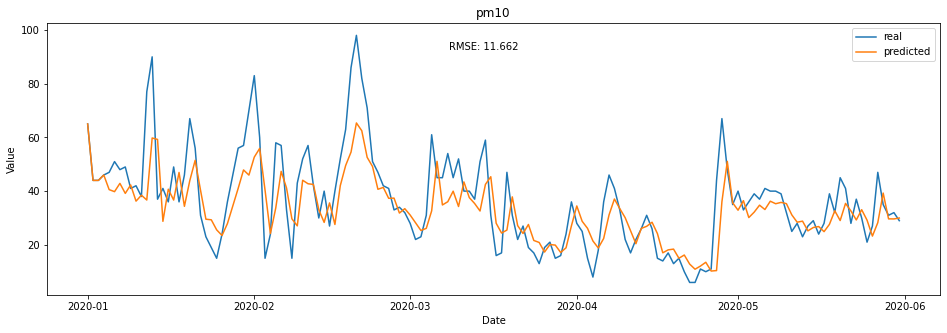

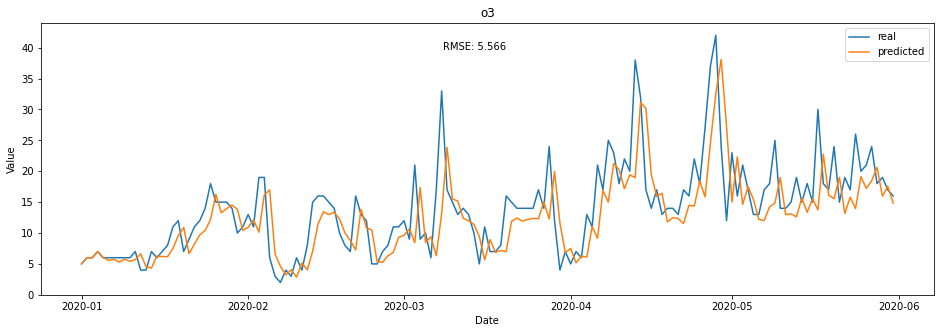

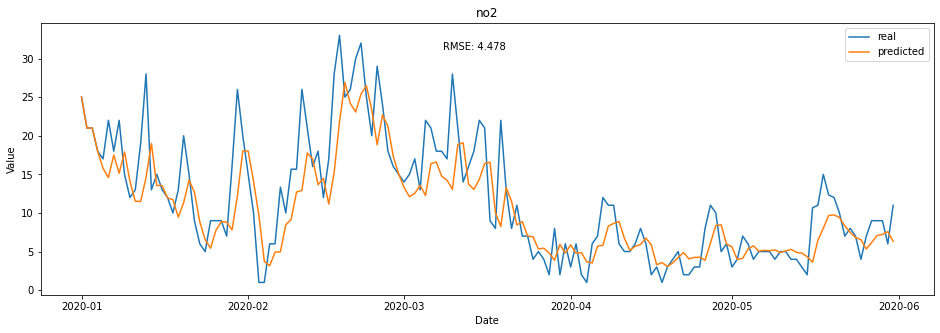

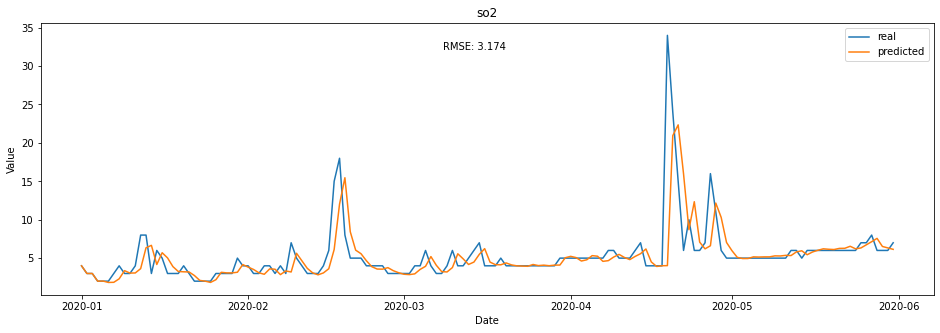

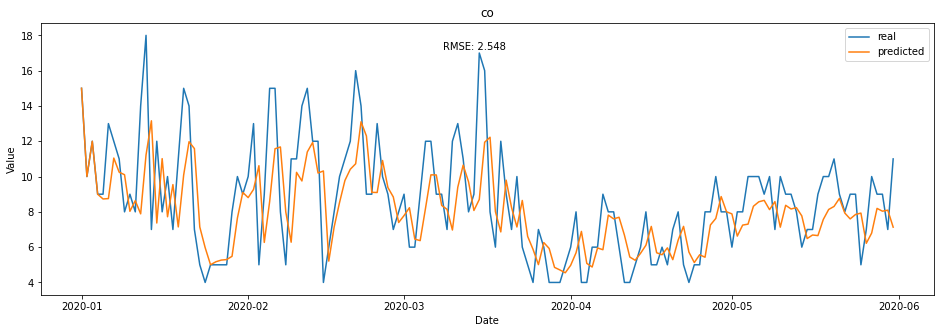

In [25]:
evaluate([y_hat_pm25, y_hat_pm10, y_hat_o3, y_hat_no2, y_hat_so2, y_hat_co], n_in, n_out)